In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import os
import sys
from torchvision import models
import torch.nn as nn
import torchsummary

In [2]:
import os


current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
BASE_DIR = os.path.basename(project_root)

## 1. Construct Dataset with Fourier Transform

In [ ]:
# def fft_mag_image(split, image_path, target_image_size):
#     # Image path: Image

#     pil_image = Image.open(image_path).convert("RGB")
#     gray = np.array(pil_image.convert("L"))
#     F = np.fft.fft2(gray)
#     F_shift = np.fft.fftshift(F)

#     # Apply log1p to avoid large exponential
#     log_mag = np.log1p(np.abs(F_shift))

#     # Normalize down to range [0, 1]
#     mag_norm = (log_mag - log_mag.min()) / (log_mag.max() - log_mag.min())
#     mag_norm_resize = cv2.resize(mag_norm, dsize=target_image_size)

#     image_name = image_path.split("/")[-1].split(".")[0]
#     # Save in format: fourier/split/image_name.npy
#     # Save this in npy format
#     split_path = os.path.join(f"{project_root}/fourier", split)
#     os.makedirs(split_path, exist_ok=True)
#     save_path = f"{project_root}/fourier/{split}/{image_name}"
#     np.save(save_path, mag_norm_resize)


# splits = ["train", "val", "test"]

# for split in splits:
#     split_path = os.path.join(f"{project_root}/data", split)
#     for label in os.listdir(split_path):
#         label_path = os.path.join(split_path, label)
#         for item in os.listdir(label_path):
#             item_path = os.path.join(label_path, item)
#             fft_mag_image(split, item_path, target_image_size=(224, 224))

In [33]:

from src.dataloader import get_data_loaders
from src.train import train_one_epoch, evaluate
from src.utils import (
    set_seed,
    save_checkpoint,
    save_experiment_json,
    get_device,
    plot_history,
    error_analysis,
    plot_error_analysis
    
)

In [4]:
CLASS = ["real", "fake"]
BATCH_SIZE = 32
DEVICE = get_device()
TASK_NAME = "deepfake_detection"
EPOCHS_STAGE_1 = 10  # General configuration
LR_STAGE_1 = 1e-3  # General configuration
EPOCHS_STAGE_2 = 20  # General configuration
LR_STAGE_2 = 1e-5  # General configuration
MODEL_NAME = "efficient-net"
set_seed(42)
print(f"Using device: {DEVICE}")

Using device: mps


In [5]:
data_path = os.path.join(project_root, "data")

## 2. EfficientNet

In [6]:

train_loader, val_loader, test_loader = get_data_loaders(
    data_path,
    MODEL_NAME,
    BATCH_SIZE,
    use_fourier_transform=True,
    use_augmentation=True
)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import torch.nn.functional as F


def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training")

    for _, fourier_mags, images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        fourier_mags = fourier_mags.to(device)
        optimizer.zero_grad()

        outputs = model(fourier_mags, images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc


def evaluate_step(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_preds = []
    all_probs_real = []

    with torch.no_grad():
        for _, fourier_mags, images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            fourier_mags = fourier_mags.to(device)
            outputs = model(fourier_mags, images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs_real.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / total_samples
    avg_acc = correct_predictions / total_samples

    f1 = f1_score(all_labels, all_preds, average="binary")

    try:
        auc = roc_auc_score(all_labels, all_probs_real)
    except ValueError:
        auc = 0.0

    return avg_loss, avg_acc, f1, auc

In [8]:
class EfficientNetDFWithFourier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze all model weights
        for param in model.parameters():
            param.requires_grad = False

        # Remove the classifier layer in model
        self.feature_extractor = nn.Sequential()
        for name, module in model.named_children():
            if name == "classifier":
                break
            self.feature_extractor.add_module(name, module)

        self.fourier_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1),
        )

        num_features = model.classifier[1].in_features + 32

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True), nn.Linear(num_features, num_classes)
        )

    def forward(self, fourier_mag, img):
        img_features = self.feature_extractor(img)
        img_features_flatten = torch.flatten(img_features, start_dim=1)
        fourier_features = self.fourier_extractor(fourier_mag)
        fourier_features_flatten = torch.flatten(fourier_features, start_dim=1)
        concat_features = torch.concat(
            (img_features_flatten, fourier_features_flatten), dim=1
        )

        output = self.classifier(concat_features)
        return output

In [9]:
model = EfficientNetDFWithFourier()

# Get number of trained parameters for this model
def get_num_trained_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trained parameters: {get_num_trained_parameters(model)}")


Number of trained parameters: 12322


In [15]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_1, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [16]:
history_aug = {
    "model_name": MODEL_NAME,
    "model_saved_path": "",
    "weight_decay": WEIGHT_DECAY,
    "label_smoothing": LABEL_SMOOTHING,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": [],
    "best_epoch": [],
}

best_acc = 0.0

In [19]:
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier.pth"
)

print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


[1/10] train_acc: 0.6153 - train_loss: 0.6589 - valid_acc: 0.6255 - valid_loss: 0.6471
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 1 - acc: 0.6255



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


[2/10] train_acc: 0.6360 - train_loss: 0.6492 - valid_acc: 0.6433 - valid_loss: 0.6412
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 2 - acc: 0.6433



Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


[3/10] train_acc: 0.6469 - train_loss: 0.6411 - valid_acc: 0.6413 - valid_loss: 0.6435
	- [current best] epoch: 2 - acc: 0.6433



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


[4/10] train_acc: 0.6430 - train_loss: 0.6447 - valid_acc: 0.6399 - valid_loss: 0.6428
	- [current best] epoch: 2 - acc: 0.6433



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


[5/10] train_acc: 0.6492 - train_loss: 0.6430 - valid_acc: 0.6490 - valid_loss: 0.6392
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 5 - acc: 0.6490



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.35it/s]


[6/10] train_acc: 0.6418 - train_loss: 0.6462 - valid_acc: 0.6396 - valid_loss: 0.6448
	- [current best] epoch: 5 - acc: 0.6490



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


[7/10] train_acc: 0.6425 - train_loss: 0.6445 - valid_acc: 0.6205 - valid_loss: 0.6695
	- [current best] epoch: 5 - acc: 0.6490



Evaluating: 100%|██████████| 94/94 [00:49<00:00,  1.91it/s]


[8/10] train_acc: 0.6441 - train_loss: 0.6441 - valid_acc: 0.6544 - valid_loss: 0.6384
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 8 - acc: 0.6544



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


[9/10] train_acc: 0.6447 - train_loss: 0.6457 - valid_acc: 0.6480 - valid_loss: 0.6414
	- [current best] epoch: 8 - acc: 0.6544



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]

[10/10] train_acc: 0.6461 - train_loss: 0.6417 - valid_acc: 0.6409 - valid_loss: 0.6453
	- [current best] epoch: 8 - acc: 0.6544



In [20]:
# Load the best state again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

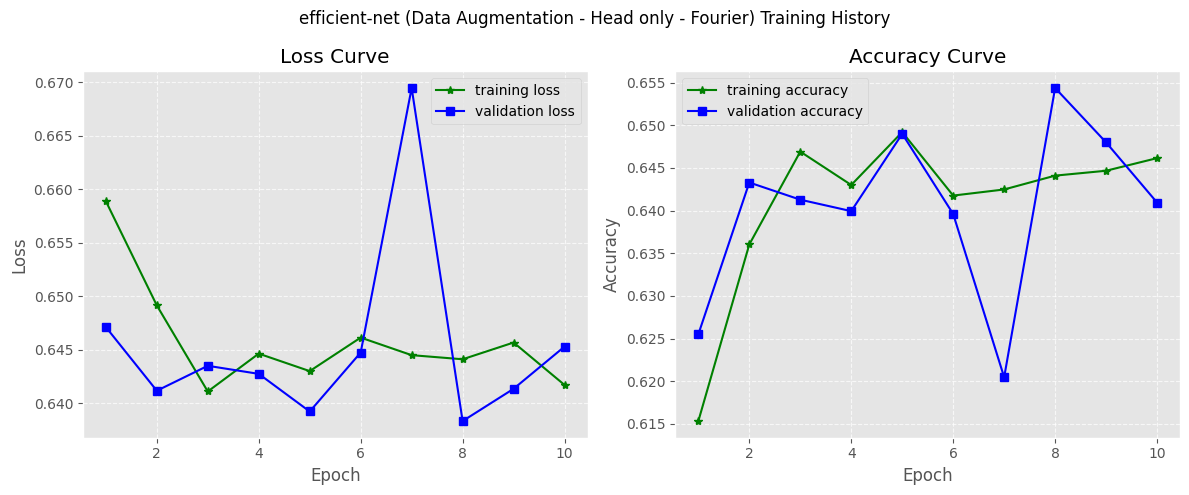

In [21]:
model_saved_name = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier"
plot_history(
    history_aug,
    f"{MODEL_NAME} (Data Augmentation - Head only - Fourier) Training History",
    f"{model_saved_name}.png",
)

In [22]:
for param in model.parameters():
    param.requires_grad = True

print(f"Number of trained parameters: {get_num_trained_parameters(model)}")

Number of trained parameters: 4019870


In [63]:
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

In [ ]:
model = model.to(device=DEVICE)


optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_2, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [24]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)

print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


[11/30 (Fine-Tune)] train_acc: 0.6899 - train_loss: 0.6066 - valid_acc: 0.7134 - valid_loss: 0.5781
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7134



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


[12/30 (Fine-Tune)] train_acc: 0.7451 - train_loss: 0.5533 - valid_acc: 0.7581 - valid_loss: 0.5347
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7581



Evaluating: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


[13/30 (Fine-Tune)] train_acc: 0.7899 - train_loss: 0.5032 - valid_acc: 0.8013 - valid_loss: 0.4986
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 13 - acc: 0.8013



Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.84it/s]


[14/30 (Fine-Tune)] train_acc: 0.8235 - train_loss: 0.4638 - valid_acc: 0.8201 - valid_loss: 0.4739
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8201



Evaluating: 100%|██████████| 94/94 [00:55<00:00,  1.71it/s]


[15/30 (Fine-Tune)] train_acc: 0.8476 - train_loss: 0.4341 - valid_acc: 0.8362 - valid_loss: 0.4564
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8362



Evaluating: 100%|██████████| 94/94 [00:59<00:00,  1.58it/s]


[16/30 (Fine-Tune)] train_acc: 0.8677 - train_loss: 0.4116 - valid_acc: 0.8507 - valid_loss: 0.4416
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8507



Evaluating: 100%|██████████| 94/94 [00:50<00:00,  1.88it/s]


[17/30 (Fine-Tune)] train_acc: 0.8818 - train_loss: 0.3940 - valid_acc: 0.8597 - valid_loss: 0.4331
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8597



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


[18/30 (Fine-Tune)] train_acc: 0.8925 - train_loss: 0.3770 - valid_acc: 0.8721 - valid_loss: 0.4208
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 18 - acc: 0.8721



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


[19/30 (Fine-Tune)] train_acc: 0.9013 - train_loss: 0.3671 - valid_acc: 0.8742 - valid_loss: 0.4132
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8742



Evaluating: 100%|██████████| 94/94 [00:46<00:00,  2.02it/s]


[20/30 (Fine-Tune)] train_acc: 0.9066 - train_loss: 0.3577 - valid_acc: 0.8809 - valid_loss: 0.4019
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 20 - acc: 0.8809



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


[21/30 (Fine-Tune)] train_acc: 0.9114 - train_loss: 0.3509 - valid_acc: 0.8772 - valid_loss: 0.4074
	- [current best] epoch: 20 - acc: 0.8809



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


[22/30 (Fine-Tune)] train_acc: 0.9188 - train_loss: 0.3408 - valid_acc: 0.8906 - valid_loss: 0.3930
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 22 - acc: 0.8906



Evaluating: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


[23/30 (Fine-Tune)] train_acc: 0.9272 - train_loss: 0.3307 - valid_acc: 0.8909 - valid_loss: 0.3940
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 23 - acc: 0.8909



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


[24/30 (Fine-Tune)] train_acc: 0.9302 - train_loss: 0.3270 - valid_acc: 0.8936 - valid_loss: 0.3972
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 24 - acc: 0.8936



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[25/30 (Fine-Tune)] train_acc: 0.9318 - train_loss: 0.3211 - valid_acc: 0.8956 - valid_loss: 0.3925
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 25 - acc: 0.8956



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


[26/30 (Fine-Tune)] train_acc: 0.9385 - train_loss: 0.3149 - valid_acc: 0.8943 - valid_loss: 0.3930
	- [current best] epoch: 25 - acc: 0.8956



Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


[27/30 (Fine-Tune)] train_acc: 0.9425 - train_loss: 0.3106 - valid_acc: 0.8946 - valid_loss: 0.3902
	- [current best] epoch: 25 - acc: 0.8956



Evaluating: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


[28/30 (Fine-Tune)] train_acc: 0.9440 - train_loss: 0.3085 - valid_acc: 0.8973 - valid_loss: 0.3778
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


[29/30 (Fine-Tune)] train_acc: 0.9465 - train_loss: 0.3041 - valid_acc: 0.8956 - valid_loss: 0.3785
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [00:47<00:00,  1.97it/s]

[30/30 (Fine-Tune)] train_acc: 0.9473 - train_loss: 0.2995 - valid_acc: 0.8913 - valid_loss: 0.3868
	- [current best] epoch: 28 - acc: 0.8973



In [71]:
EPOCHS_STAGE_3 = 10
LR_STAGE_3 = 1e-5

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_3, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [72]:
# Continue fine-tuning the model
TOTAL_EPOCHS_PREV = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
TOTAL_EPOCHS = TOTAL_EPOCHS_PREV + EPOCHS_STAGE_3
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)

print(
    f"Training configuration for stage 3: LR = {LR_STAGE_3}, EPOCHS = {EPOCHS_STAGE_3}"
)
for epoch in range(TOTAL_EPOCHS_PREV, TOTAL_EPOCHS):
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 3: LR = 1e-05, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.30it/s]


[31/40 (Fine-Tune)] train_acc: 0.9489 - train_loss: 0.2997 - valid_acc: 0.8919 - valid_loss: 0.3922
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


[32/40 (Fine-Tune)] train_acc: 0.9481 - train_loss: 0.3012 - valid_acc: 0.8956 - valid_loss: 0.3881
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [00:46<00:00,  2.04it/s]


[33/40 (Fine-Tune)] train_acc: 0.9462 - train_loss: 0.3007 - valid_acc: 0.8953 - valid_loss: 0.3826
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [00:46<00:00,  2.03it/s]


[34/40 (Fine-Tune)] train_acc: 0.9492 - train_loss: 0.2997 - valid_acc: 0.8960 - valid_loss: 0.3792
	- [current best] epoch: 28 - acc: 0.8973



Evaluating: 100%|██████████| 94/94 [01:18<00:00,  1.19it/s]


[35/40 (Fine-Tune)] train_acc: 0.9474 - train_loss: 0.3018 - valid_acc: 0.9000 - valid_loss: 0.3799
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 35 - acc: 0.9000



Evaluating: 100%|██████████| 94/94 [00:54<00:00,  1.73it/s]


[36/40 (Fine-Tune)] train_acc: 0.9485 - train_loss: 0.3010 - valid_acc: 0.8990 - valid_loss: 0.3767
	- [current best] epoch: 35 - acc: 0.9000



Evaluating: 100%|██████████| 94/94 [00:54<00:00,  1.73it/s]


[37/40 (Fine-Tune)] train_acc: 0.9520 - train_loss: 0.2966 - valid_acc: 0.8990 - valid_loss: 0.3771
	- [current best] epoch: 35 - acc: 0.9000



Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


[38/40 (Fine-Tune)] train_acc: 0.9511 - train_loss: 0.2976 - valid_acc: 0.9007 - valid_loss: 0.3763
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 38 - acc: 0.9007



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


[39/40 (Fine-Tune)] train_acc: 0.9495 - train_loss: 0.3006 - valid_acc: 0.8963 - valid_loss: 0.3799
	- [current best] epoch: 38 - acc: 0.9007



Evaluating: 100%|██████████| 94/94 [00:56<00:00,  1.66it/s]

[40/40 (Fine-Tune)] train_acc: 0.9483 - train_loss: 0.2986 - valid_acc: 0.8966 - valid_loss: 0.3802
	- [current best] epoch: 38 - acc: 0.9007



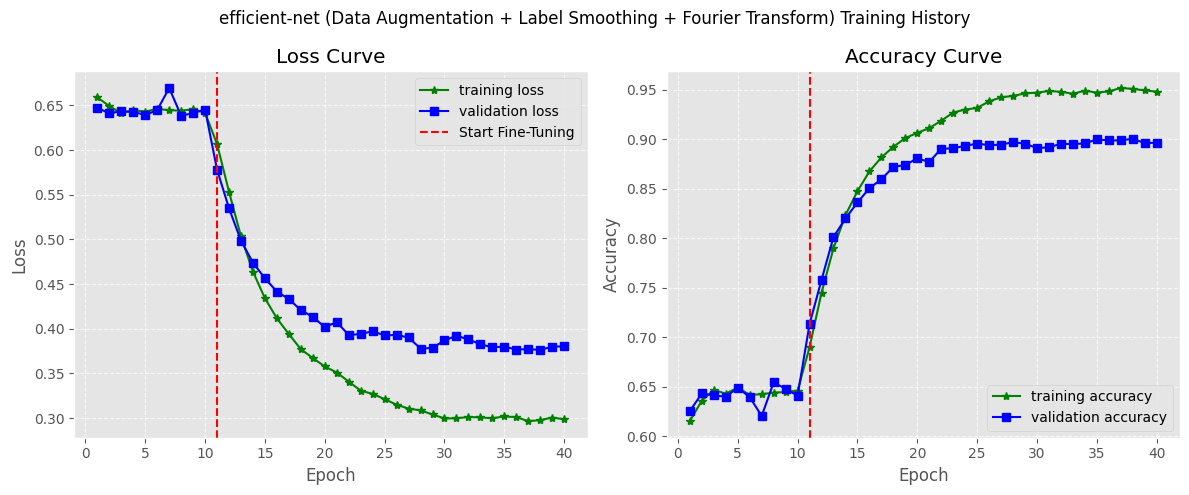

In [73]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_augmentation_fourier_finetuned_{TASK_NAME}"
)
plot_history(
    history_aug,
    f"{MODEL_NAME} (Data Augmentation + Label Smoothing + Fourier Transform) Training History",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [74]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_all_predictions(model, loader, device):
    """
    Runs inference on the entire loader and returns all true labels and predictions.
    """
    model.eval()
    y_pred = []
    y_true = []
    originals = []
    with torch.no_grad():
        for original_batch, fourier_mags, images, labels in tqdm(loader, desc="Getting predictions"):
            images = images.to(device)
            labels = labels.to(device)
            fourier_mags = fourier_mags.to(device)
            outputs = model(fourier_mags, images)
            _, preds = torch.max(outputs, 1)

            originals.extend(original_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return originals, y_true, y_pred


def performance(
    model, loader, device, model_name, save_path=None, class_names=["real", "fake"]
):
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

    _, y_true, y_pred = get_all_predictions(model, loader, device)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy score: {acc:.4f}")

    print("Classification Report")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="crest",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    if save_path is not None:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

Getting predictions: 100%|██████████| 95/95 [00:42<00:00,  2.23it/s]

Accuracy score: 0.8983
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1510
           1       0.90      0.90      0.90      1510

    accuracy                           0.90      3020
   macro avg       0.90      0.90      0.90      3020
weighted avg       0.90      0.90      0.90      3020



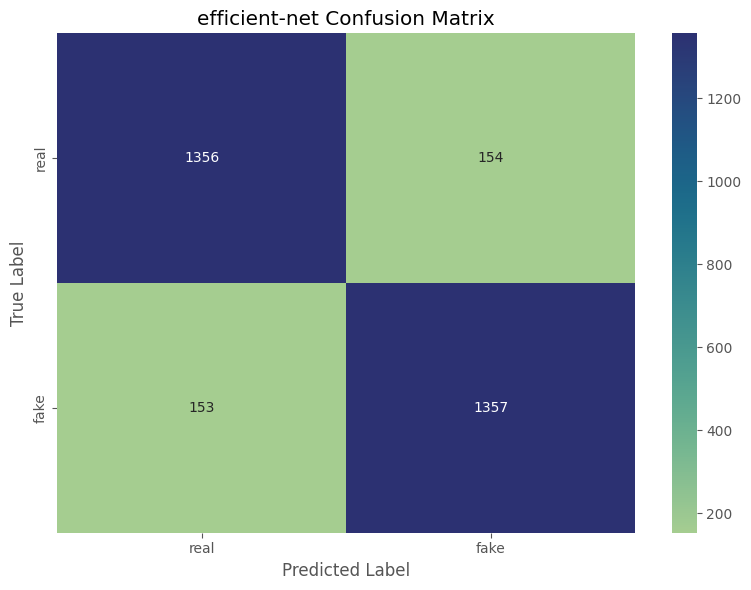

In [76]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, save_path=save_path)

In [77]:
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned_history.json")
save_experiment_json(history_aug, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/efficient-net_deepfake_detection_augmentation_fourier_finetuned_history.json


In [ ]:
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)
checkpoint = torch.load(model_save_path, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])


In [78]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE, use_fourier_transform=True)


Deepfakes : 0.9371
Face2Face : 0.8874
FaceSwap : 0.8808
FaceShifter : 0.9404
NeuralTextures : 0.8477


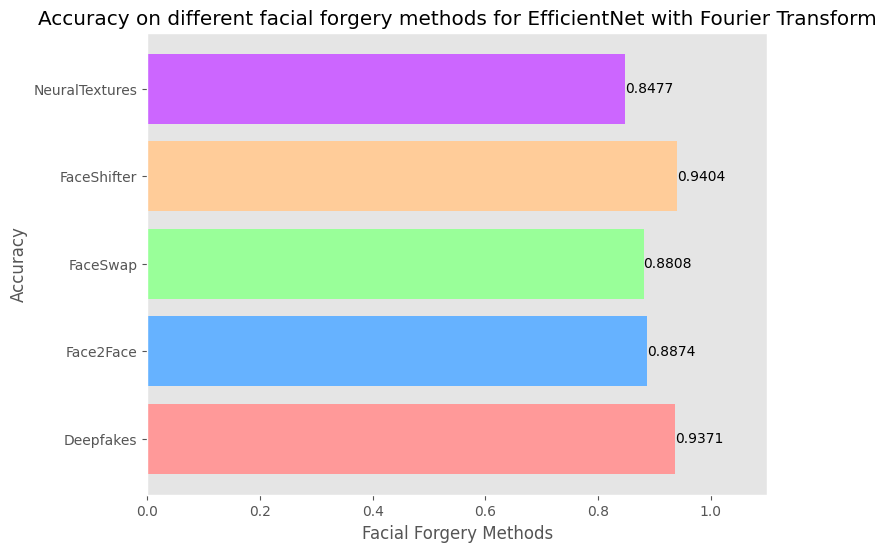

In [80]:
plot_error_analysis(summary, model_name = "EfficientNet with Fourier Transform")